In [39]:
# load data
import pandas as pd
import numpy as np

data = pd.read_csv("data/heart.csv")

In [40]:
data.head() # an overview on data 

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [41]:
data.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


In [42]:
# displaying correlations for target column
data.corr()["target"]

age        -0.225439
sex        -0.280937
cp          0.433798
trestbps   -0.144931
chol       -0.085239
fbs        -0.028046
restecg     0.137230
thalach     0.421741
exang      -0.436757
oldpeak    -0.430696
slope       0.345877
ca         -0.391724
thal       -0.344029
target      1.000000
Name: target, dtype: float64

As we could see 2 biggest correlation are:
 - *cp* - it's the type of chest pain the patient have. 
 - *exang* - Exercise induced angina. 
> For NOTE: angina - is chest pain caused usually by insufficient blood flow.

Although this correlation are the biggest one, for showing decision boundary I will choose:
 - thalach - The person's   maximum heart rate achieved
 - oldpeak - ST depression induced by exercise relative to rest    

In [43]:
selected_columns = data[["thalach", "oldpeak", "target"]] 
selected_columns.head()

,thalach,oldpeak,target
0,150,2.3,1
1,187,3.5,1
2,172,1.4,1
3,178,0.8,1
4,163,0.6,1


<Axes: xlabel='thalach', ylabel='oldpeak'>

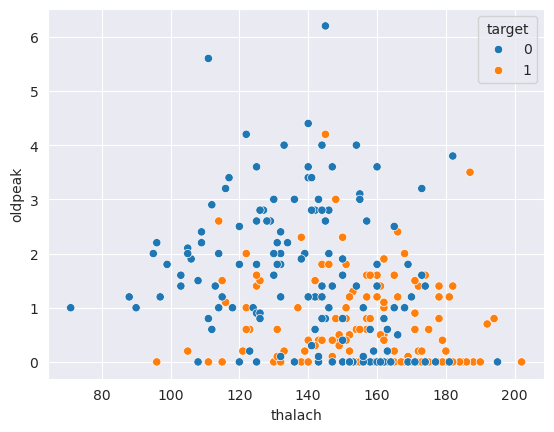

In [44]:
# a look on the data

import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x="thalach", y="oldpeak", hue="target", data = selected_columns)

### Logistic Regression

In [45]:
# train prediction model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

model = LogisticRegression()


X = selected_columns.drop(columns=["target"]).to_numpy()
y = selected_columns["target"].to_numpy()

X, X_test, y, y_test = train_test_split(X,y, test_size=0.3)
model.fit(X, y)

yhat = model.predict(X_test)
acc = accuracy_score(y_test, yhat)
print(f"Accuracy: {acc} (LogisticRegression)")

Accuracy: 0.7362637362637363 (LogisticRegression)


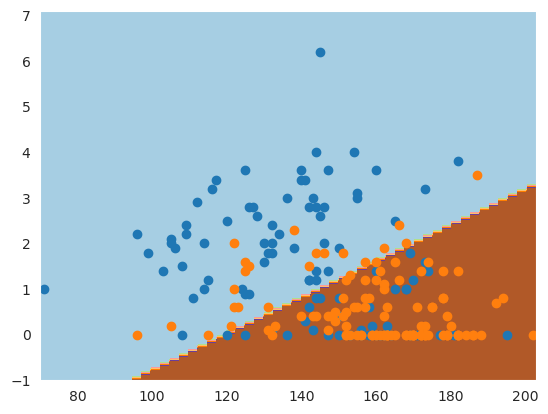

In [46]:
# graphical representation of LogisticRegression  

from matplotlib import pyplot

min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)
xx, yy = np.meshgrid(x1grid, x2grid)
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
grid = np.hstack((r1,r2))
yhat = model.predict(grid)
zz = yhat.reshape(xx.shape)
pyplot.contourf(xx, yy, zz, cmap='Paired')

for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = np.where(y == class_value)
    # create scatter of these samples
    plt.scatter(X[row_ix, 0], X[row_ix, 1])

### Decision Tree

<Axes: xlabel='thalach', ylabel='oldpeak'>

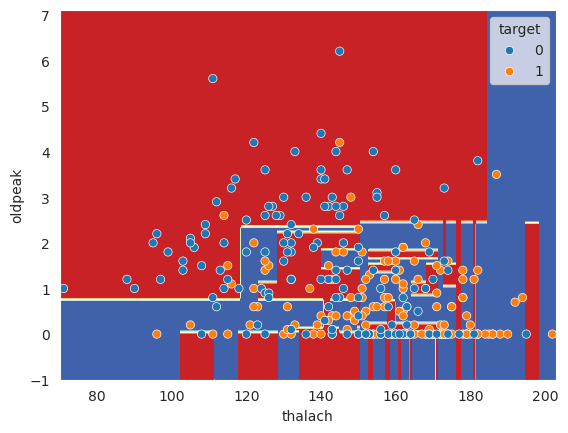

In [47]:
# graphical representation of DecisionTreeClassifier 

from sklearn.tree import DecisionTreeClassifier, plot_tree

clf = DecisionTreeClassifier().fit(X, y)

plot_step = 0.1

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

sns.scatterplot(x="thalach", y="oldpeak", hue="target", data = selected_columns)


Accuracy DecisionTreeClassifier: 0.6373626373626373 (without hyperparameters tunning)


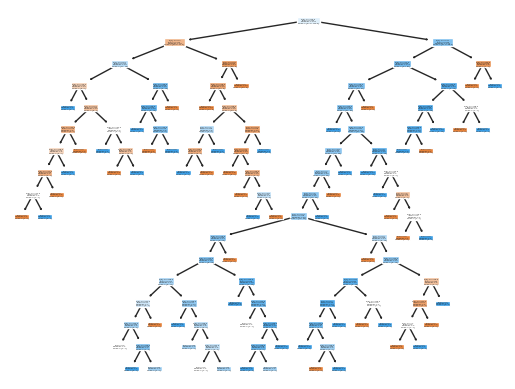

In [48]:
plt.figure()
clf = DecisionTreeClassifier().fit(X, y)
y_predicted = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
print(f"Accuracy DecisionTreeClassifier: {accuracy} (without hyperparameters tunning)")
plot_tree(clf, filled=True)
plt.show()

The resulted tree is so complex because there is no max_depth specified which means the algorithm is expanding until all leaves are pure or until all leaves contain less than min_samples_split samples.

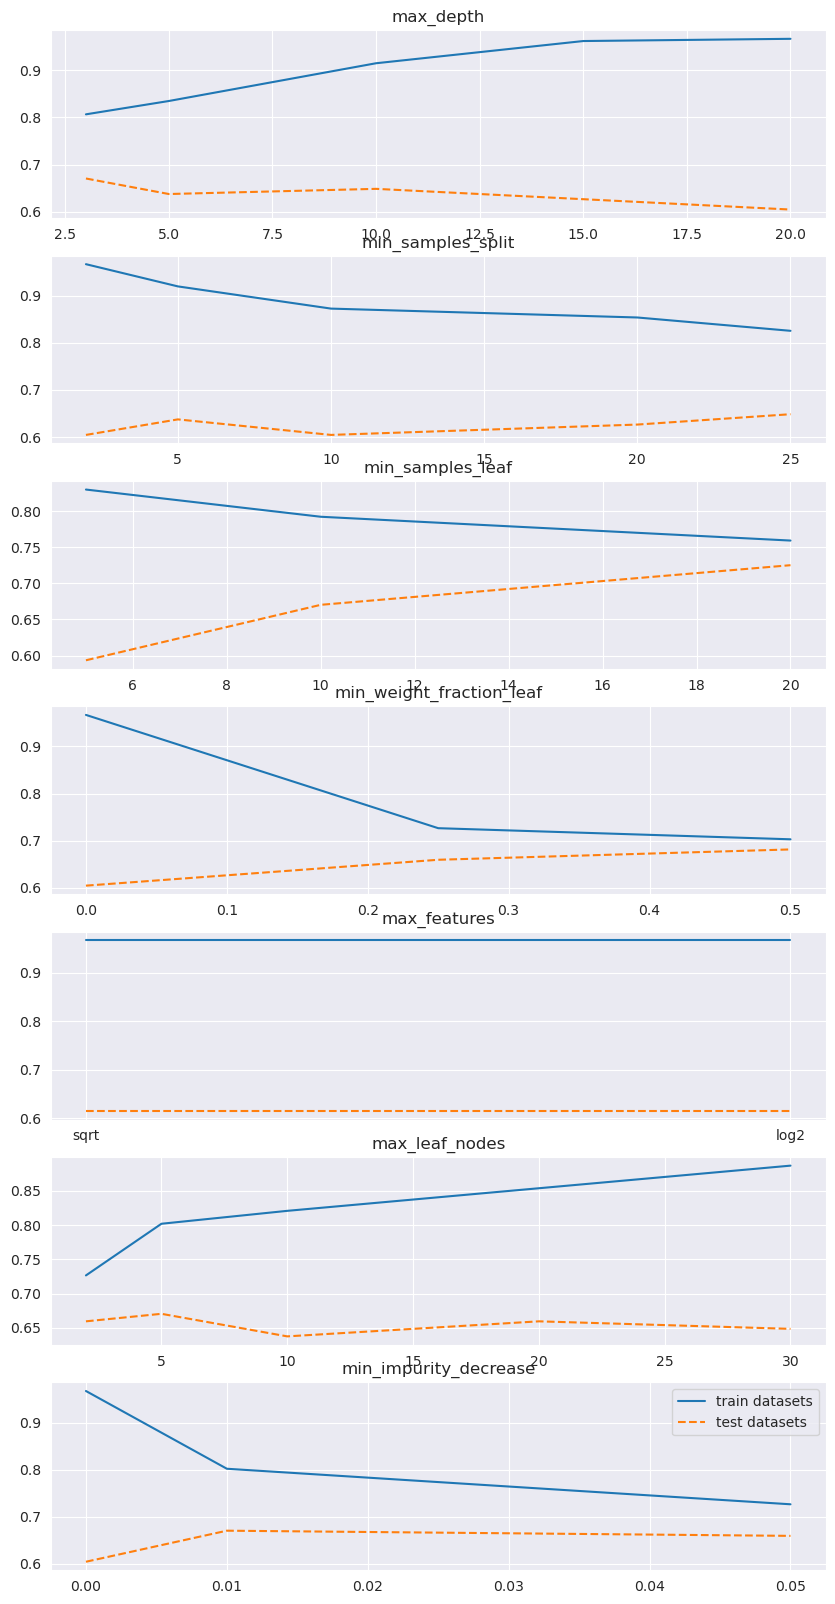

In [52]:

random_state = 42

# setting hyperparameters

params_grid = {
    'max_depth': [3, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10,20,25],
    'min_samples_leaf': [5,10,20],
    'min_weight_fraction_leaf': [0.0, 0.25, 0.5],
    'max_features': ['sqrt', 'log2'],
    'max_leaf_nodes': [2,5,10, 20, 30],
    'min_impurity_decrease': [0.0, 0.01, 0.05],
}



index = 0 
fig, axs = plt.subplots(len(params_grid),figsize=(10, 20))
for hyperparameter, values in params_grid.items():
    accuracies = []
    accuracies_test = []
    
    for value in values:
        init_parameters = {hyperparameter: value, "random_state": 42}
        clf = DecisionTreeClassifier(**init_parameters)
        clf.fit(X, y) # train for each hyperparmeter
        y_predicted_data = clf.predict(X) 
        y_predicted_test = clf.predict(X_test)
        accuracy = accuracy_score(y, y_predicted_data)
        accuracy_test = accuracy_score(y_test, y_predicted_test)
        accuracies.append(accuracy)
        accuracies_test.append(accuracy_test)
    
    axs[index].plot( values, accuracies, label= "train")
    axs[index].plot( values, accuracies_test, linestyle='--', label ="test")
    axs[index].set_title(hyperparameter)
    index += 1 # crazy algorithms (o_O )
    plt.legend(["train datasets", "test datasets"])

### hyper-parameters

`max_depth` - influence how much in depth the trees  go. also as we could observe the a greater value leads to overfiting. 

 `min_samples_split` -  minimum required nr of samples to split the node,  a lower value leads to overfiting  

`min_sample_leaf` - minimum number of samples required to be at a leaf node. again a lower value leads to overfiting. 

`min_weight_fraction_leaf` - minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. a lower value leads to overfiting 

`max_features` -  the number of features to consider when looking for the best split. don't influence at all 

`max_leaf_nodes` - the number of leafs in total. A lesser value leads to underfiting

`min_inpurity_decrease` -  a node will be split if this split induces a decrease of the impurity greater than.  a smaller value will lead to overfiting 
 

### Conclusion
Generally speaking this hyperparameters influence the overfiting or underfiting. And should be considered to change in dependence of the dataset.

### Best hyperparameters 

In [50]:
# find the best parameters

from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier()

gridscv = GridSearchCV(clf, params_grid, cv=5,return_train_score=True)

gridscv.fit(X, y)
best_fitted_hyperparameters = gridscv.best_params_
best_fitted_hyperparameters

{'max_depth': 3,
 'max_features': 'log2',
 'max_leaf_nodes': 30,
 'min_impurity_decrease': 0.01,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0}

Accuracy DeccisionTreeClasifier: 0.6703296703296703 (with hyperparameters tunning)


[Text(0.5, 0.8333333333333334, 'x[1] <= 1.85\ngini = 0.496\nsamples = 212\nvalue = [97.0, 115.0]'),
 Text(0.25, 0.5, 'x[0] <= 150.5\ngini = 0.448\nsamples = 165\nvalue = [56, 109]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.492\nsamples = 57\nvalue = [32, 25]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.346\nsamples = 108\nvalue = [24, 84]'),
 Text(0.75, 0.5, 'x[0] <= 161.0\ngini = 0.223\nsamples = 47\nvalue = [41.0, 6.0]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.095\nsamples = 40\nvalue = [38, 2]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.49\nsamples = 7\nvalue = [3, 4]')]

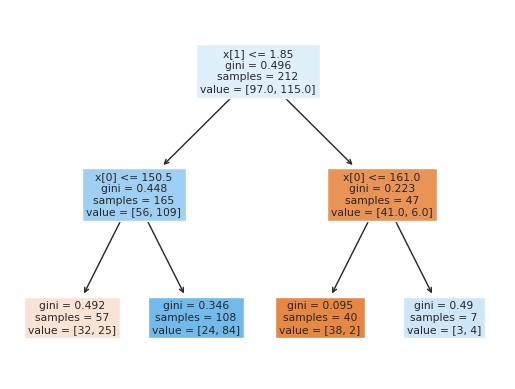

In [51]:
# train with best suited parameters

best_clf = DecisionTreeClassifier(
    **best_fitted_hyperparameters,
) 

best_clf.fit(X,y)
y_predicted = best_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_predicted)
print(f"Accuracy DeccisionTreeClasifier: {accuracy} (with hyperparameters tunning)")
plot_tree(best_clf, filled=True)
 

### Conclusion

| **Model**                               | **Accuracy** |
| --------------------------------------- | ------------ |
| LogisticRegrresion                      | 0.758        |
| DecisionTreeClassifire(without tunning) | 0.571        |
| DecisionTreeClasifire(tunned)           | 0.791        |

DecisionTreeClassifier is a great tool when features are not linear.  
